## Goal 2: Predict actual power generation by wind plants of SP15 hub on 2024-04-09



In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Load the provided time series data
file_path = '/Users/lok/5DE/data/DAM_ACTUAL.csv'
data = pd.read_csv(file_path)
data.head()

,OPR_DT,OPR_HR,TRADING_HUB,RENEWABLE_TYPE,MW,MARKET_RUN_ID
0,2024-03-16,1,SP15,Wind,86.06151,ACTUAL
1,2024-03-16,1,SP15,Wind,181.85000,DAM
2,2024-03-16,2,SP15,Wind,44.73634,ACTUAL
3,2024-03-16,2,SP15,Wind,214.71000,DAM
4,2024-03-16,3,SP15,Wind,93.95260,ACTUAL


In [3]:
# Separating actual and predicted data
actual_data = data[data['MARKET_RUN_ID'] == 'ACTUAL']
predicted_data = data[data['MARKET_RUN_ID'] == 'DAM']

# Renaming 'MW' columns 
actual_data = actual_data.rename(columns={'MW': 'Actual_MW'})
predicted_data = predicted_data.rename(columns={'MW': 'Predicted_MW'})

# Merging the datasets on date and hour
merged_data = pd.merge(actual_data, predicted_data, on=['OPR_DT', 'OPR_HR', 'TRADING_HUB', 'RENEWABLE_TYPE'], how='inner')

# Display the merged dataset structure
relevant_data = merged_data[['Actual_MW', 'Predicted_MW']]

relevant_data.head()

,Actual_MW,Predicted_MW
0,86.06151,181.85
1,44.73634,214.71
2,93.95260,219.87
3,212.32840,226.03
4,294.56320,254.62


In [4]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(relevant_data)

In [5]:
# Function to create sequences with both actual and predicted data
def create_sequences(input_data, sequence_length):
    xs = []
    ys = []
    for i in range(len(input_data)-sequence_length):
        x = input_data[i:(i+sequence_length), :]
        y = input_data[i+sequence_length, 0]  # We are predicting the next actual value
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Creating sequences
sequence_length = 24  # using 24 hours of data to predict the next hour
X, y = create_sequences(normalized_data, sequence_length)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [6]:
class WindGenerationLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=50, output_size=1):
        super(WindGenerationLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [7]:
# Instantiating the model
model = WindGenerationLSTM()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # adjust step_size and gamma as needed

# Training the model
epochs = 30

train_losses = []
val_losses = []

for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()  # Set the model to training mode
    total_train_loss = 0

    # Training loop
    for seq, labels in zip(X_train_tensor, y_train_tensor):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        train_loss = loss_function(y_pred, labels)
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()

    avg_train_loss = total_train_loss / len(X_train_tensor)
    train_losses.append(avg_train_loss)
    scheduler.step()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0
        for seq, labels in zip(X_val_tensor, y_val_tensor):
            y_pred = model(seq)
            labels = labels.unsqueeze(0)
            val_loss = loss_function(y_pred, labels)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(X_val_tensor)
        val_losses.append(avg_val_loss)


    print(f'Epoch {epoch+1} \t Training Loss: {avg_train_loss:.4f} \t Validation Loss: {avg_val_loss:.4f}')


Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/lok/miniconda3/envs/5de/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 	 Training Loss: 0.0212 	 Validation Loss: 0.0309
Epoch 2 	 Training Loss: 0.0118 	 Validation Loss: 0.0162
Epoch 3 	 Training Loss: 0.0077 	 Validation Loss: 0.0084
Epoch 4 	 Training Loss: 0.0057 	 Validation Loss: 0.0053
Epoch 5 	 Training Loss: 0.0048 	 Validation Loss: 0.0036
Epoch 6 	 Training Loss: 0.0040 	 Validation Loss: 0.0029
Epoch 7 	 Training Loss: 0.0035 	 Validation Loss: 0.0031
Epoch 8 	 Training Loss: 0.0034 	 Validation Loss: 0.0026
Epoch 9 	 Training Loss: 0.0029 	 Validation Loss: 0.0027
Epoch 10 	 Training Loss: 0.0028 	 Validation Loss: 0.0027
Epoch 11 	 Training Loss: 0.0027 	 Validation Loss: 0.0024
Epoch 12 	 Training Loss: 0.0029 	 Validation Loss: 0.0026
Epoch 13 	 Training Loss: 0.0026 	 Validation Loss: 0.0026
Epoch 14 	 Training Loss: 0.0025 	 Validation Loss: 0.0026
Epoch 15 	 Training Loss: 0.0023 	 Validation Loss: 0.0027
Epoch 16 	 Training Loss: 0.0023 	 Validation Loss: 0.0028
Epoch 17 	 Training Loss: 0.0023 	 Validation Loss: 0.0027
Epoch 

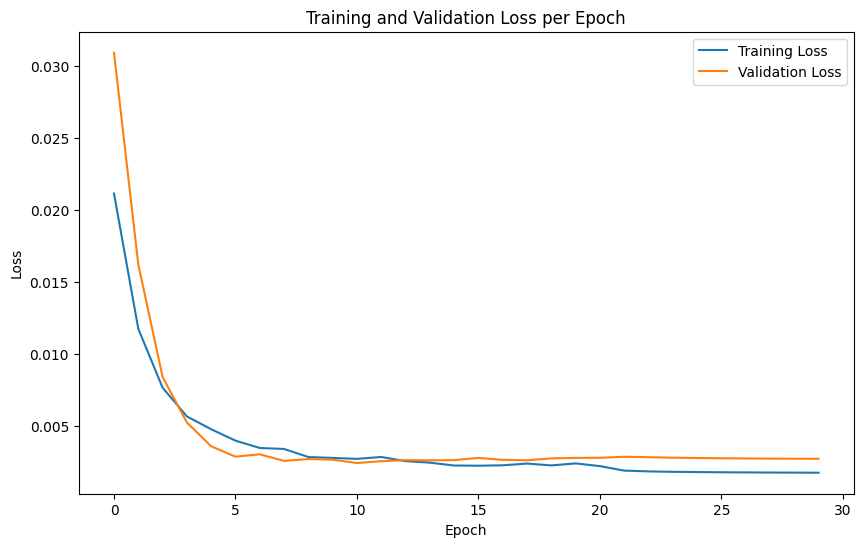

In [9]:
# Plotting the training and validation loss graph
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()